---
title: "Run simulation"
format: html
jupyter: python3
---

# Run simulation 

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns

from array_to_df import using_multiindex

R = 50

R_myopic = 0.5  # Base reward for myopic solution
R_optimal = 1  # Base reward for optimal solution
epsilon = 0.1

In [75]:
def grid_dict(params):
    keys = list(params)
    grids = np.meshgrid(*[params[k] for k in keys], indexing="ij")
    flat = [g.ravel() for g in grids]
    return {k: v for k, v in zip(keys, flat)}

In [ ]:
def individual_learning(q_opt, d_myopic, d_optimal, k):
    # effective number of trails
    k_opt = np.random.binomial(k, q_opt)
    k_myo = k - k_opt

    # probability of discovery
    d_opt_total = 1.0 - np.power(1.0 - d_optimal[:,np.newaxis], k_opt)
    d_myo_total = 1.0 - np.power(1.0 - d_myopic[:,np.newaxis], k_myo)

    u = np.random.rand(*q_opt.shape)
    discovered_optimal = (u < d_opt_total)
    discovered_myopic  = (~discovered_optimal) & (u < (d_opt_total + (1.0 - d_opt_total) * d_myo_total))

    s_post = np.ones_like(q_opt) * -1
    s_post = np.where(discovered_myopic, 0, s_post)
    s_post = np.where(discovered_optimal, 1, s_post)

    return s_post

def demonstration(K_demonstration, s_post):
    n_optimal = np.where(s_post == 1, K_demonstration, 0)
    n_myopic = np.where(s_post == 0, K_demonstration, 0)
    return n_optimal, n_myopic

def get_rewards(n_optimal, n_myopic, K_demonstration, epsilon):
    base_reward = n_optimal * R_optimal + n_myopic * R_myopic
    sigma_eff = epsilon * np.sqrt(K_demonstration)
    noise = np.random.normal(0, sigma_eff[:,np.newaxis], size=base_reward.shape)
    return base_reward + noise


def get_teacher_indices(prev_rewards, n_teacher, tau, eps=1e-12):
    M, N_gen = prev_rewards.shape
    teacher_indices = np.empty((M, N_gen), dtype=int)

    n_teacher = np.asarray(n_teacher, dtype=int)
    tau = np.asarray(tau, dtype=float)

    for m in range(M):
        k = int(n_teacher[m])

        candidates = np.random.rand(N_gen, N_gen).argsort(axis=1)[:, :k]

        logits = prev_rewards[m, candidates] / tau[m]
        logits -= logits.max(axis=1, keepdims=True)

        weights = np.exp(logits)
        probs = weights / (weights.sum(axis=1, keepdims=True) + eps)

        cdf = np.cumsum(probs, axis=1)
        u = np.random.rand(N_gen, 1)
        chosen_within_k = (u > cdf).sum(axis=1)

        teacher_indices[m] = candidates[np.arange(N_gen), chosen_within_k]

    return teacher_indices




def social_learning(q_opt_post, teacher_indices, lambda_):
    M = q_opt_post.shape[0]
    N_gen = q_opt_post.shape[1]
    m_idx = np.arange(M)[:,np.newaxis]
    q_opt_social = q_opt_post[m_idx, teacher_indices]
    is_learned = (np.random.rand(M, N_gen) < lambda_[:,np.newaxis])
    q_opt_social = np.where(is_learned, q_opt_social, 0)
    return q_opt_social

def run_simulation(d, G, N_gen, N_mach, K_demo):
    M = len(d['replication'])
    is_machine = np.zeros((M, G, N_gen), dtype=bool)
    is_machine[d['condition'] == 'human-machine',0,:N_mach] = True
    is_machine[d['condition'] == 'human-machine-all',:,:N_mach] = True

    print(is_machine.mean())

    K_ind = np.ones((M, G, N_gen), dtype=int) * d['K_human'][:,np.newaxis,np.newaxis]
    K_ind = np.where(is_machine, d['K_machine'][:,np.newaxis,np.newaxis], K_ind)

    q_opt = np.ones((M, G, N_gen)) * d['q_opt_human'][:,np.newaxis,np.newaxis]
    q_opt = np.where(is_machine, d['q_opt_machine'][:,np.newaxis,np.newaxis], q_opt)


    n_optimal = np.empty((M, G, N_gen))
    n_myopic = np.empty((M, G, N_gen))

    rewards = np.empty((M, G, N_gen))

    cond = d['condition']
    d_optimal_log = d['d_optimal_log']
    d_opt = np.power(10, d_optimal_log)
    d_myo = d['d_myopic']
    n_t = d['n_teacher']
    l = d['lambda']
    e = d['epsilon']
    tau = d['tau']

    for g in range(G):
        print(f"Generation {g+1}")
        # print("Individual learning")
        s_ind = individual_learning(q_opt[:,g], d_myo, d_opt, K_ind[:,g])
        if g > 0:
            # print("Select teacher")
            teacher_indices = get_teacher_indices(rewards[:,g-1], n_t, tau)
            s_social = social_learning(s, teacher_indices, l)
            s = np.maximum(s_ind, s_social)
        else:
            s = s_ind
        # print("Demonstration")
        n_optimal[:,g], n_myopic[:,g] = demonstration(K_demo, s)
        rewards[:,g] = get_rewards(n_optimal[:,g], n_myopic[:,g], K_demo, e)

    rewards_df = using_multiindex(rewards, ['rep', 'gen', 'agent'], value_name='rewards')
    n_optimal_df = using_multiindex(n_optimal, ['rep', 'gen', 'agent'], value_name='optimal')
    n_myopic_df = using_multiindex(n_myopic, ['rep', 'gen', 'agent'], value_name='myopic')
    is_machine_df = using_multiindex(is_machine, ['rep', 'gen', 'agent'], value_name='is_machine')


    meta_df = pd.DataFrame(d)
    meta_df['rep'] = np.arange(len(meta_df))

    df = meta_df.merge(rewards_df, on='rep')
    df = df.merge(n_optimal_df, on=['rep', 'gen', 'agent'])
    df = df.merge(n_myopic_df, on=['rep', 'gen', 'agent'])
    df = df.merge(is_machine_df, on=['rep', 'gen', 'agent'])
    df['human-optimal'] = ~df['is_machine'] * df['optimal']
    df['discovered'] = (df.groupby(['rep', 'gen'])['human-optimal'].transform('sum') > 0)
    df['learnability difficulty'] = 1 - df['lambda']
    df['discoverability difficulty'] = -df['d_optimal_log']
    df['myopic bias'] = 1 - df['q_opt_human'] * 2
    df['myopic bias intensity'] = np.log((1 - df['q_opt_human']) / df['q_opt_human'])
    return df

In [ ]:
SKIP_SIMULATION = False

N_gen = 20  # Number of agents per generation
N_mach = 0  # Number of machines
G = 20
K_demo = 10

K_human = np.logspace(1, 4, 10, base=10, endpoint=True).astype(int)
K_machine = [0] # not used

q_opt_human = np.logspace(-8, -1, 8, base=2, endpoint=True)
q_opt_machine = [0] # not used

n_teacher = [10] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)

lambda_ = [0.9]  # Social learning rate
conditions = ['human']
tau = [0.1]


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': [epsilon],
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
    'tau': tau,
}

d = grid_dict(grid_d)
if not SKIP_SIMULATION:
    df = run_simulation(d, G, N_gen, N_mach, K_demo)
    df_agg = df.groupby(['rep','replication', 'gen', 'K_human', 'discoverability difficulty', 'myopic bias intensity']).agg(
        {
            'discovered': 'max',
            'optimal': 'mean',
            'myopic': 'mean',
            'rewards': 'mean',
        }
    ).sort_index()
    df_agg.to_parquet('../data/abm/bias_discoverability.parquet')
else:
    df_agg = pd.read_parquet('../data/abm/bias_discoverability.parquet')

0.0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20


/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_70570/3083641581.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_yticklabels(axs[3].get_yticklabels())  # keep colorbar tick labels


[]

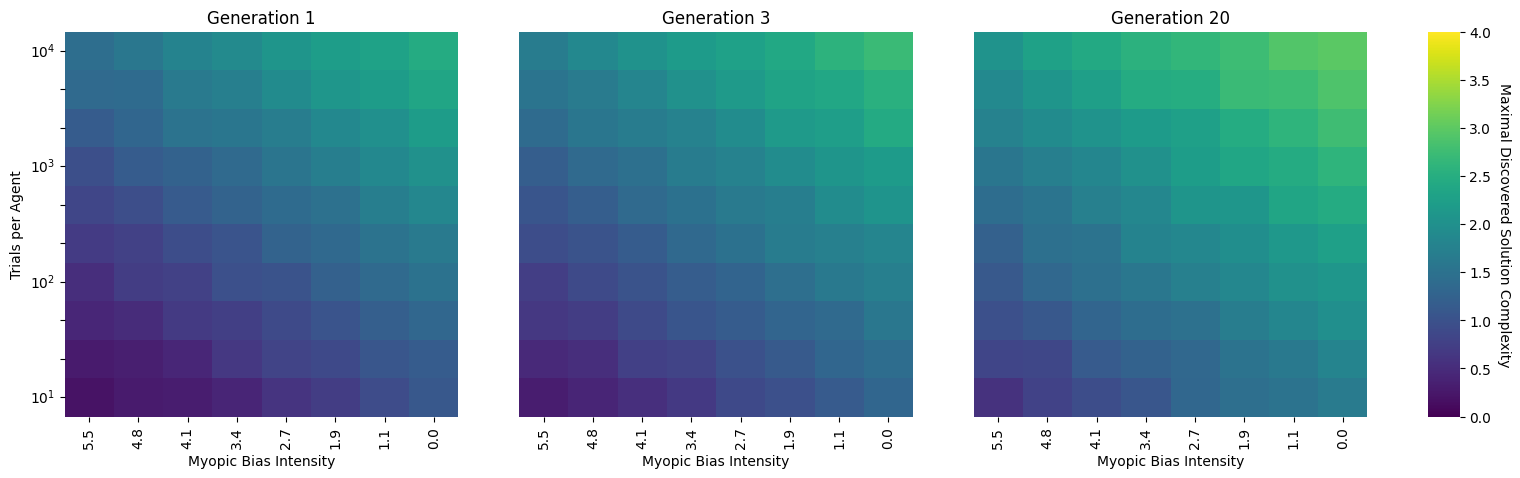

In [78]:
max_discovered = df_agg[df_agg['discovered']].reset_index().groupby(['gen', 'K_human', 'myopic bias intensity', 'rep'])['discoverability difficulty'].max().reset_index()

m = max_discovered.reset_index().pivot_table(index=['gen', 'K_human'],
                               columns='myopic bias intensity', values='discoverability difficulty').sort_index()

import matplotlib.pyplot as plt

m = m.sort_index(axis=0, ascending=False)
m = m.sort_index(axis=1, ascending=False)
# Three plots next to each other, plus a fourth axis for the shared colorbar
fig, axs = plt.subplots(1, 4, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1, 0.08]})


hm = sns.heatmap(m.loc[0], ax=axs[0], cbar=False, cmap='viridis', vmin=0, vmax=4)
hm = sns.heatmap(m.loc[2], ax=axs[1], cbar=False, cmap='viridis', vmin=0, vmax=4)
hm = sns.heatmap(m.loc[19], ax=axs[2], cbar=False, cmap='viridis', vmin=0, vmax=4)

# Put the colorbar in its own (fourth) axis so all three heatmaps have equal size
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[3])
# Remove border around the colorbar
cbar.outline.set_visible(False)
# Set new label for the colorbar
cbar.ax.set_ylabel('Maximal Discovered Solution Complexity', rotation=-90, va="bottom")

axs[0].set_ylabel('Trials per Agent')
# Remove the y-axis labels for plot 2 and 3
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_xlabel('Myopic Bias Intensity')
axs[1].set_xlabel('Myopic Bias Intensity')
axs[2].set_xlabel('Myopic Bias Intensity')


# Format the y-ticks (one significant digit)
yvals = m.loc[0].index.values
mask = np.isclose(np.log10(yvals) % 1, 0)
axs[0].set_yticklabels([rf"$10^{int(np.log10(v))}$" if m else '' for v,m in zip(yvals, mask)])

# Remove tick labels for plot 2 and 3
axs[1].set_yticks([])
axs[2].set_yticks([])

# Format the x-ticks (one significant digit)
tick_labels = [f"{x:.1f}" for x in m.columns]
# axs[0].set_xticks(rm1.columns)
axs[0].set_xticklabels(tick_labels)
# axs[1].set_xticks(rm1.columns)
axs[1].set_xticklabels(tick_labels)
# axs[2].set_xticks(rm1.columns)
axs[2].set_xticklabels(tick_labels)

axs[0].set_title('Generation 1')
axs[1].set_title('Generation 3')
axs[2].set_title('Generation 20')

# Hide ticks and labels on the colorbar axis except for the bar itself
axs[3].set_yticklabels(axs[3].get_yticklabels())  # keep colorbar tick labels
axs[3].set_xticks([])

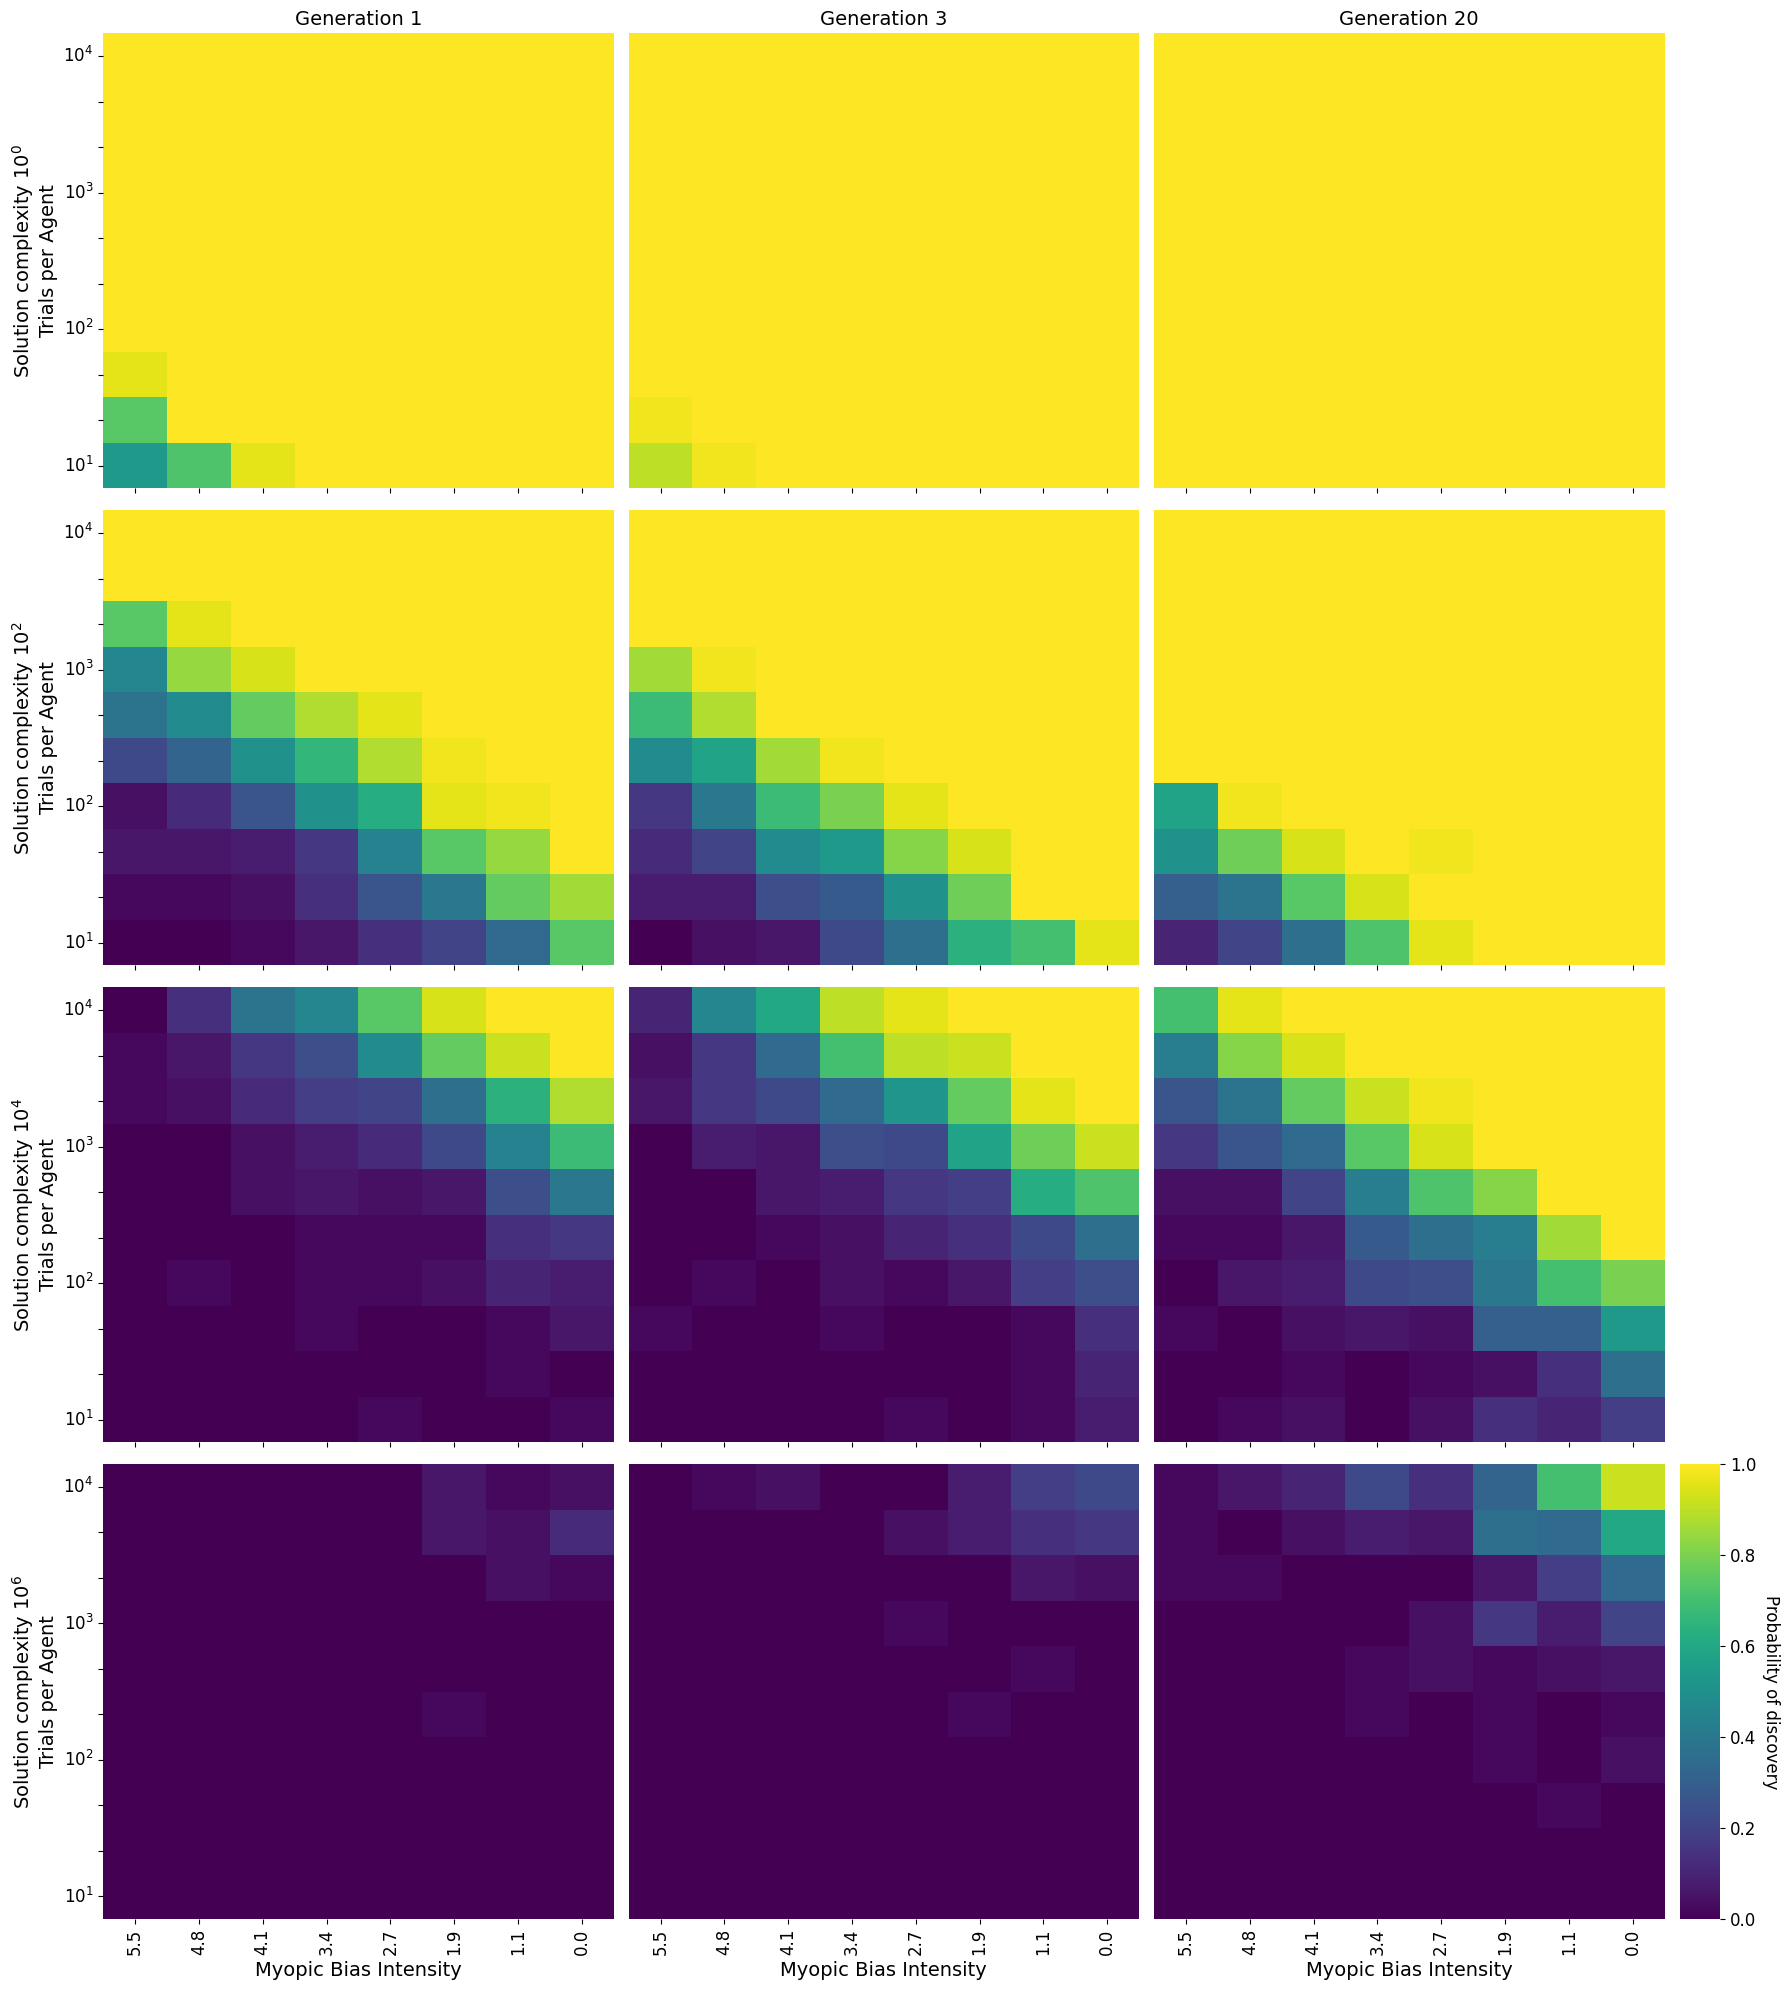

In [79]:
dd_values = [0, 2, 4, 6]

m = df_agg.reset_index().pivot_table(index=['gen', 'discoverability difficulty', 'K_human'],
                               columns='myopic bias intensity', values='discovered')

import matplotlib.pyplot as plt

# Ensure MultiIndex is lexicographically sorted to avoid PerformanceWarning
m = m.sort_index(axis=0)
# Sort columns in descending order for display
m = m.sort_index(axis=1, ascending=False)

# Reset index once to avoid MultiIndex access issues
m_reset = m.reset_index()

generations = [0, 2, 19]

# Create a 4x4 grid: 4 rows (one for each dd_value) and 4 columns (3 for generations + 1 for colorbar)
fig, axs = plt.subplots(len(dd_values), 4, figsize=(18, 5*len(dd_values)), 
                        gridspec_kw={"width_ratios": [1, 1, 1, 0.08]})

# Loop through dd_values (rows) and generations (columns)
for row_idx, dd_val in enumerate(dd_values):
    for col_idx, gen in enumerate(generations):
        # Access data by filtering on reset index to avoid MultiIndex PerformanceWarning
        data_df = m_reset[(m_reset['gen'] == gen) & (m_reset['discoverability difficulty'] == dd_val)]
        data_df = data_df.set_index('K_human')[m.columns]
        # Ensure the DataFrame index is sorted for heatmap
        data_df = data_df.sort_index(ascending=False)
        ax = axs[row_idx, col_idx]
        
        # Create heatmap - convert DataFrame to numpy array for clean 2D structure
        data_array = data_df.values
        hm = sns.heatmap(data_array, ax=ax, cbar=False, cmap='viridis', vmin=0, vmax=1,
                        xticklabels=data_df.columns, yticklabels=data_df.index)
        
        # Set labels
        if col_idx == 0:
            ax.set_ylabel(
                rf'Solution complexity $10^{dd_val}$' '\n'
                r'Trials per Agent'
            ,size=14)
            # Format the y-ticks (one significant digit)
            yvals = data_df.index.values
            mask = np.isclose(np.log10(yvals) % 1, 0)
            ax.set_yticklabels([rf"$10^{int(np.log10(v))}$" if mask_val else '' for v,mask_val in zip(yvals, mask)], size=12)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        if row_idx == len(dd_values) - 1:
            ax.set_xlabel('Myopic Bias Intensity', size=14)
            # Format the x-ticks (one significant digit)
            tick_labels = [f"{x:.1f}" for x in m.columns]
            ax.set_xticklabels(tick_labels, size=12)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        # Set titles
        if row_idx == 0:
            ax.set_title(f'Generation {gen+1}', size=14)

# Put the colorbar in the last row, rightmost column
last_row_idx = len(dd_values) - 1
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[last_row_idx, 3])
# Remove border around the colorbar
cbar.outline.set_visible(False)
# Set new label for the colorbar
cbar.ax.set_ylabel('Probability of discovery', rotation=-90, va="bottom", size=12)
cbar.ax.tick_params(labelsize=12)
axs[last_row_idx, 3].set_xticks([])

# Hide empty colorbar axes in all other rows
for row_idx in range(len(dd_values)):
    if row_idx != last_row_idx:
        axs[row_idx, 3].set_visible(False)

plt.tight_layout()
plt.savefig('plots/bias_discoverability.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('plots/bias_discoverability.pdf', bbox_inches='tight', pad_inches=0.1)


In [ ]:
SKIP_SIMULATION = False

N_gen = 20  # Number of agents per generation
N_mach = 5  # Number of machines
G = 20
K_demo = 1

K_human = [10]
K_machine = [10, 1000, 100000]

q_opt_human = [0.01]
q_opt_machine = [0.01, 0.5]

n_teacher = [10] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)

lambda_ = np.linspace(0.0, 0.5, 10)  # Social learning rate
conditions = ['human-machine']
tau = [0.1]


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': [epsilon],
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
    'tau': tau,
}

d = grid_dict(grid_d)
if not SKIP_SIMULATION:
    df = run_simulation(d, G, N_gen, N_mach, K_demo)
    gen_max = df.reset_index()['gen'].max()
    df = df[df['gen'] == gen_max]
    df_agg = df.groupby(['rep','replication', 'K_machine', 'q_opt_machine', 'discoverability difficulty', 'learnability difficulty', 'condition']).agg(
        {
            'discovered': 'max',
            'optimal': 'mean',
            'myopic': 'mean',
            'rewards': 'mean',
        }
    ).sort_index()
    df_agg.to_parquet('../data/abm/human_machine_discoverability.parquet')
else:
    df_agg = pd.read_parquet('../data/abm/human_machine_discoverability.parquet')

0.0125
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20


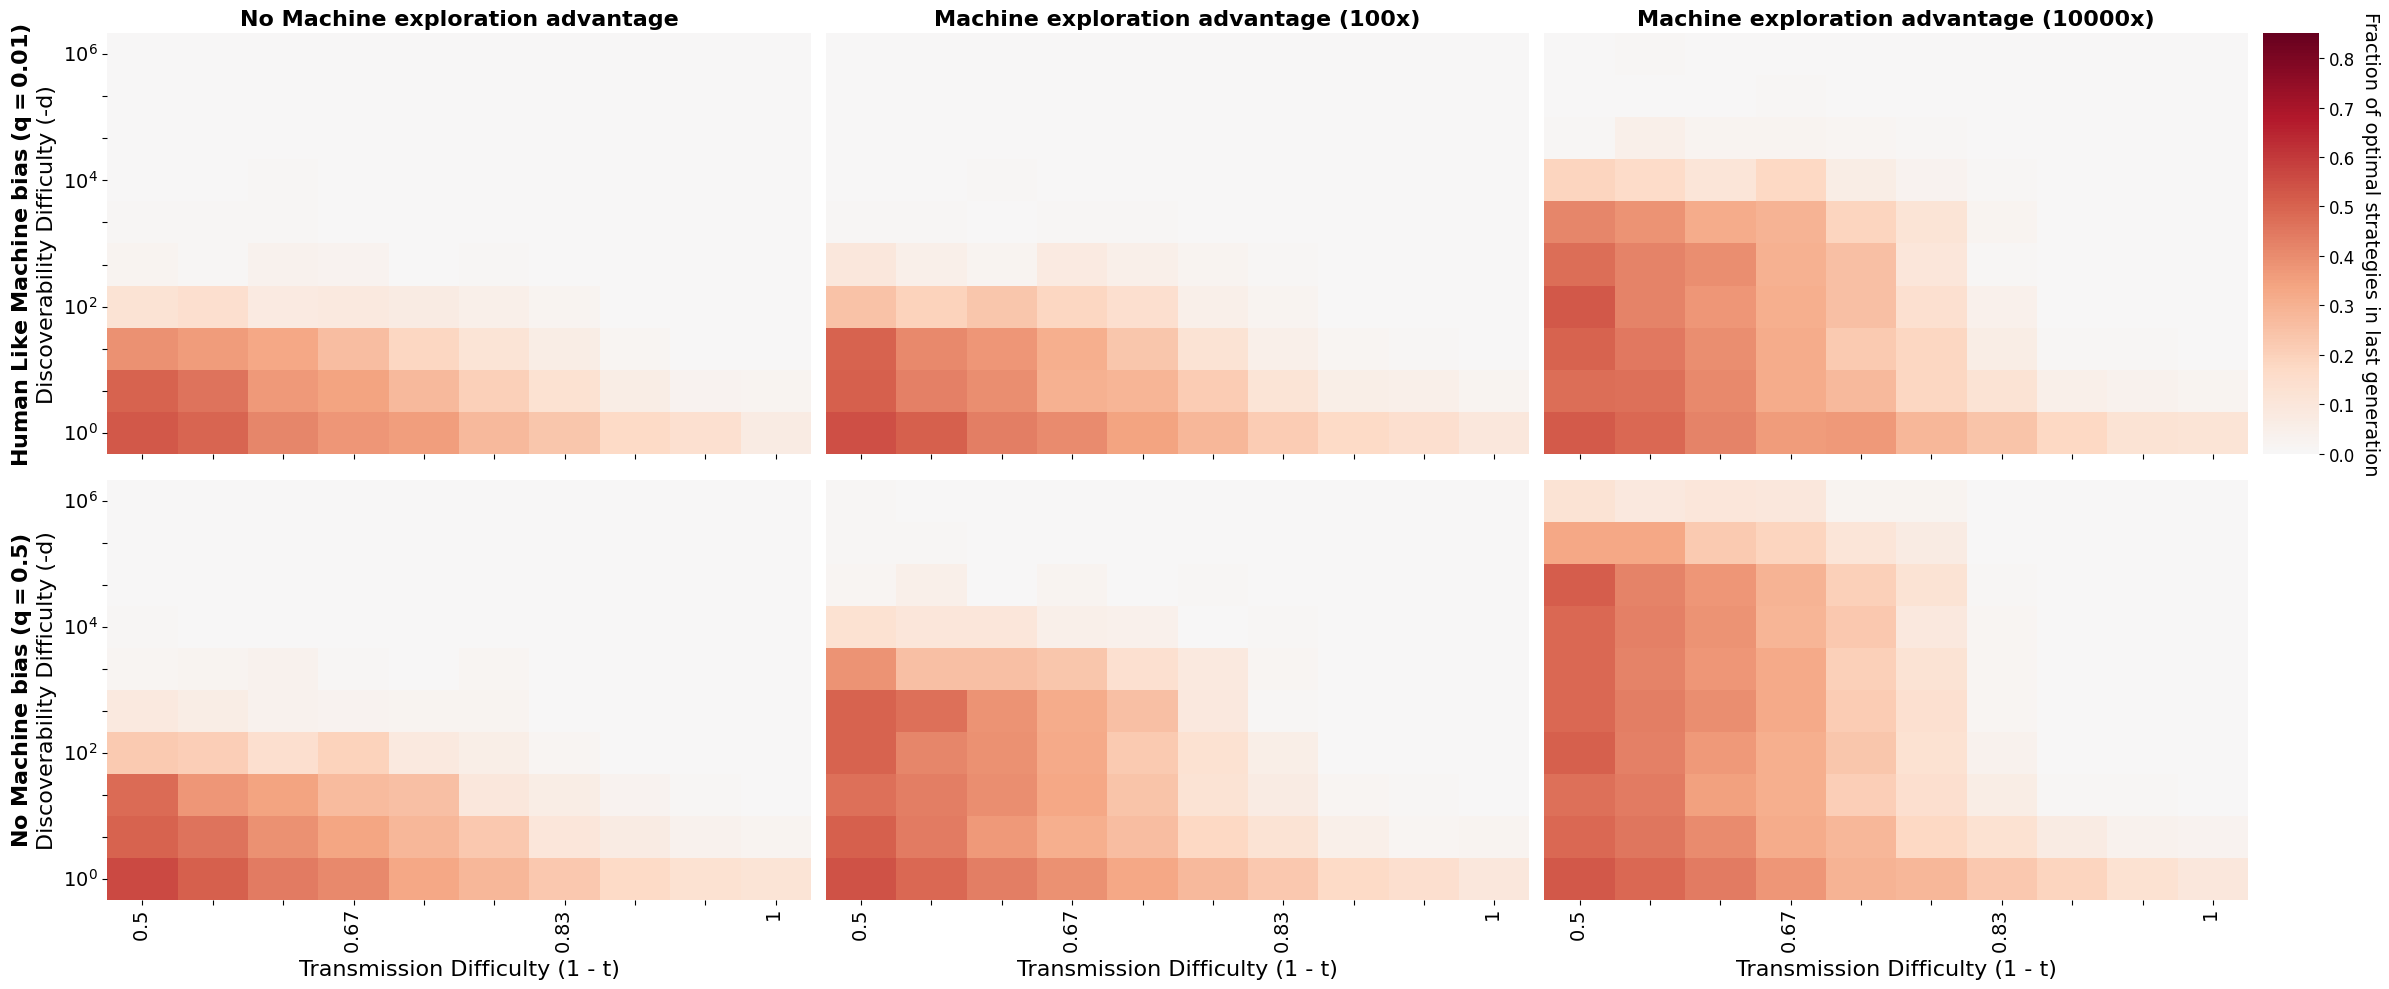

In [81]:
row_col = 'q_opt_machine'
column_col = 'K_machine'
value_col = 'optimal'
x_col = 'discoverability difficulty'
y_col = 'learnability difficulty'

df = df_agg.reset_index()

# Labels / mappings
bias_label_map = {
    0.5: r'No Machine bias (q=0.5)',
    0.01: r'Human Like Machine bias (q=0.01)',
}

K_human_base = 10  # for exploration advantage labels


column_label_map = {
    10: "No Machine exploration advantage",
}


def create_column_label(K_val):
    return column_label_map.get(K_val, f"Machine exploration advantage ({int(K_val / K_human_base)}x)")


def create_row_label(q_val):
    row_label = bias_label_map.get(q_val, rf"$q={q_val:g}$")
    # Template uses bold mathtext + escaped spaces
    row_label = row_label.replace(" ", r"\ ")
    return rf"$\mathbf{{{row_label}}}$"


x_label = r'Transmission Difficulty (1 - t)'
y_label = r'Discoverability Difficulty (-d)'

main_label_font_size = 16
tick_label_font_size = 14
legend_font_size = 14
legend_tick_label_font_size = 12

# Get unique values for rows and columns
row_values = sorted(df[row_col].unique())
column_values = sorted(df[column_col].unique())

# If you want to force specific columns (as in your current code), uncomment:
# column_values = [10, 10000]

n_rows = len(row_values)
n_cols = len(column_values)

# Create figure with subplots (add one column for colorbar)
fig, axs = plt.subplots(
    n_rows, n_cols + 1,
    figsize=(6 * (n_cols + 1), 5 * n_rows),
    gridspec_kw={"width_ratios": [1] * n_cols + [0.08]}
)

# Global color scale (template pattern)
values = df[value_col].values
vmin = 0
vmax = values.max()

# Create heatmaps for each combination
for row_idx, row_val in enumerate(row_values):
    for col_idx, column_val in enumerate(column_values):

        # Filter data for this combination
        data_subset = df[
            (df[row_col] == row_val) &
            (df[column_col] == column_val)
        ]

        # Create pivot table for heatmap
        heatmap_data = data_subset.pivot_table(
            index=x_col,
            columns=y_col,
            values=value_col
        )

        # Sort indices for proper display
        heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)
        heatmap_data = heatmap_data.sort_index(axis=1, ascending=False)

        ax = axs[row_idx, col_idx]

        hm = sns.heatmap(
            heatmap_data,
            ax=ax,
            cbar=False,
            cmap='RdBu_r',
            center=0,
            vmin=vmin,
            vmax=vmax,
            xticklabels=heatmap_data.columns,
            yticklabels=heatmap_data.index
        )

        # Invert x-axis (template behavior)
        ax.invert_xaxis()

        # --- Axis labeling / ticks (template-style) ---
        if col_idx == 0:
            row_label = create_row_label(row_val)
            ax.set_ylabel(row_label + '\n' + y_label, fontsize=main_label_font_size)

            # y ticks: show only selected powers as in the template (0,2,4,6)
            yvals = heatmap_data.index.values
            mask = np.isin(yvals, [0, 2, 4, 6])
            ax.set_yticklabels(
                [rf"$10^{{{int(v)}}}$" if m else '' for v, m in zip(yvals, mask)],
                fontsize=tick_label_font_size
            )
        else:
            ax.set_ylabel('')
            ax.set_yticks([])

        if row_idx == n_rows - 1:
            ax.set_xlabel(x_label, fontsize=main_label_font_size)

            # x ticks: 4 equally spaced ticks, 2 sig figs (template logic)
            xvals = heatmap_data.columns.values
            n_x = len(xvals)
            if n_x > 4:
                step = max(1, (n_x - 1) // 3)
                selected_indices = [0, step, 2 * step, n_x - 1]
            else:
                selected_indices = range(n_x)

            tick_labels = [
                rf"${xvals[i]:.2g}$" if i in selected_indices else '' for i in range(n_x)
            ]
            ax.set_xticklabels(tick_labels, fontsize=tick_label_font_size)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])

        # Column titles (top row only)
        if row_idx == 0:
            col_label = create_column_label(column_val)
            ax.set_title(col_label, fontsize=16, fontweight='bold')

# Add colorbar in the rightmost column
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[0, n_cols])
cbar.outline.set_visible(False)
cbar.ax.set_ylabel(
    'Fraction of optimal strategies in last generation',
    rotation=-90,
    va="bottom",
    fontsize=legend_font_size
)
cbar.ax.tick_params(labelsize=legend_tick_label_font_size)
axs[0, n_cols].set_xticks([])

# Hide empty colorbar axes in other rows
for row_idx in range(1, n_rows):
    axs[row_idx, n_cols].set_visible(False)

plt.tight_layout()

plt.savefig('plots/machine_bias_advantage.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('plots/machine_bias_advantage.pdf', bbox_inches='tight', pad_inches=0.1)


In [ ]:
SKIP_SIMULATION = False

N_gen = 20  # Number of agents per generation
N_mach = 5  # Number of machines
G = 20
K_demo = 1

K_human = [10]
K_machine = [10000]

q_opt_human = [0.01]
q_opt_machine = [0.5]

n_teacher = [10] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)

lambda_ = np.linspace(0.0, 0.5, 10)  # Social learning rate
conditions = ['human', 'human-machine', 'human-machine-all']
tau =  [0.1, 0.2, 0.4]


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': [epsilon],
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
    'tau': tau,
}

d = grid_dict(grid_d)
if not SKIP_SIMULATION:
    df = run_simulation(d, G, N_gen, N_mach, K_demo)
    gen_max = df.reset_index()['gen'].max()
    df = df[(df['gen'] == gen_max) & (df['is_machine'] == False)]
    df_agg = df.groupby(['rep','replication', 'K_machine', 'q_opt_machine', 'discoverability difficulty', 'learnability difficulty', 'condition', 'tau']).agg(
        {
            'discovered': 'max',
            'optimal': 'mean',
            'myopic': 'mean',
            'rewards': 'mean',
        }
    ).sort_index()
    df_agg.to_parquet('../data/abm/tau.parquet')
else:
    df_agg = pd.read_parquet('../data/abm/tau.parquet')

0.0875
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20


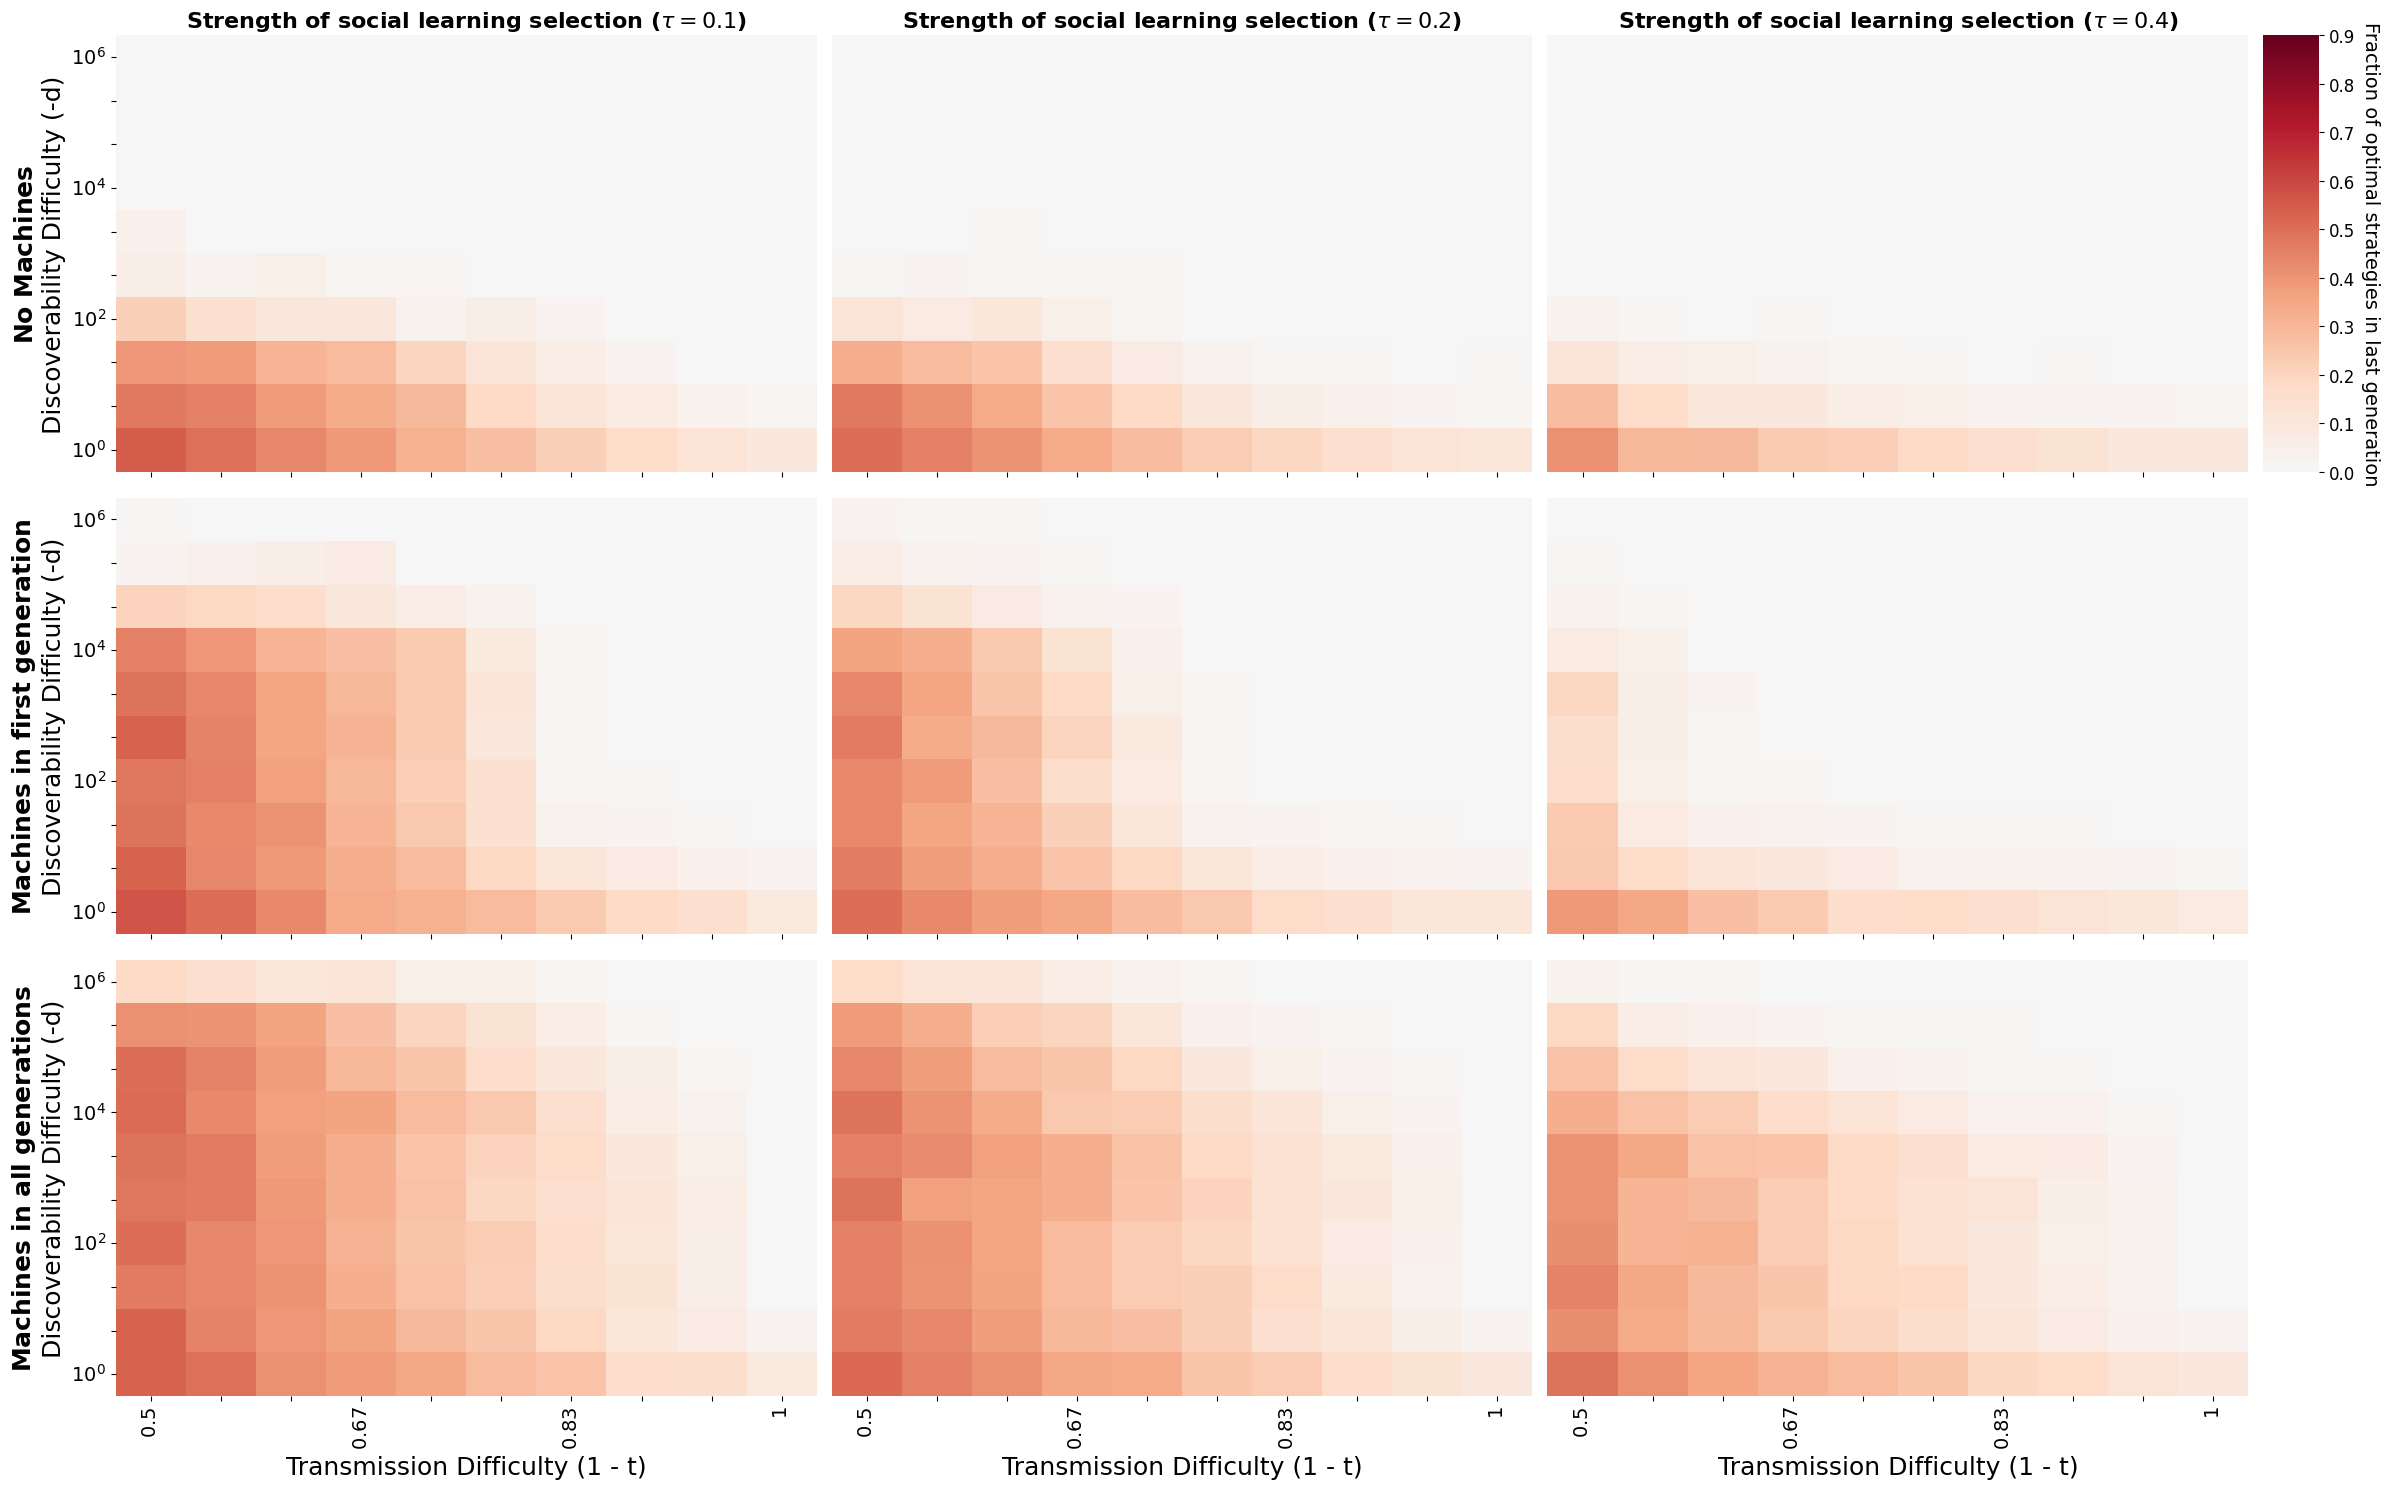

In [83]:
row_col = 'condition'
column_col = 'tau'
value_col = 'optimal'
x_col = 'discoverability difficulty'
y_col = 'learnability difficulty'


df = df_agg.reset_index()

# Get unique values for rows and columns
row_values = sorted(df[row_col].unique())
column_values = sorted(df[column_col].unique())

# Create a grid: rows = q_opt_machine, columns = K_machine
n_rows = len(row_values)
n_cols = len(column_values)

# Create figure with subplots (add one column for colorbar)
fig, axs = plt.subplots(n_rows, n_cols + 1, figsize=(6*(n_cols+1), 5*n_rows),
                        gridspec_kw={"width_ratios": [1]*n_cols + [0.08]})


def create_column_label(column_val):
    return rf"Strength of social learning selection ($\tau = {column_val}$)"

condition_label_map = {
    'human': 'No Machines',
    'human-machine': 'Machines in first generation',
    'human-machine-all': 'Machines in all generations',
}


def create_row_label(row_val):
    row_label = condition_label_map.get(row_val, f"Condition: {row_val}")
    row_label = row_label.replace(" ", r"\ ")
    return rf"$\mathbf{{{row_label}}}$"

x_label = 'Transmission Difficulty (1 - t)'
y_label = 'Discoverability Difficulty (-d)'

main_label_font_size = 18
tick_label_font_size = 14
legend_font_size = 14
legend_tick_label_font_size = 12


# Find global min/max for consistent color scale
values = df[value_col].values
vmin = values.min()
vmax = values.max()

# Create heatmaps for each combination
for row_idx, row_val in enumerate(row_values):
    for col_idx, column_val in enumerate(column_values):
        # Filter data for this combination
        data_subset = df[
            (df[row_col] == row_val) & 
            (df[column_col] == column_val)
        ]
        
        # Create pivot table for heatmap
        heatmap_data = data_subset.pivot_table(
            index=x_col,
            columns=y_col,
            values=value_col
        )
        
        # Sort indices for proper display
        heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)
        heatmap_data = heatmap_data.sort_index(axis=1, ascending=False)
        
        ax = axs[row_idx, col_idx]
        
        # Create heatmap with data labels (like the earlier plot)
        hm = sns.heatmap(heatmap_data, ax=ax, cbar=False, cmap='RdBu_r', 
                        center=0, vmin=vmin, vmax=vmax,
                        xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index)
        
        # Invert x-axis
        ax.invert_xaxis()
        
        # Set labels
        if col_idx == 0:
            row_label = create_row_label(row_val)
            ax.set_ylabel(row_label + '\n' + y_label, fontsize=main_label_font_size)
            yvals = heatmap_data.index.values
            mask = np.isin(yvals, [0, 2, 4, 6])
            ax.set_yticklabels([rf"$10^{{{int(v)}}}$" if m else '' for v, m in zip(yvals, mask)], fontsize=tick_label_font_size)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        if row_idx == n_rows - 1:
            ax.set_xlabel(x_label, fontsize=main_label_font_size)
            xvals = heatmap_data.columns.values
            n_x = len(xvals)
            if n_x > 4:
                step = max(1, (n_x - 1) // 3)
                selected_indices = [0, step, 2*step, n_x-1]
            else:
                selected_indices = range(n_x)
            tick_labels = [rf"${xvals[i]:.2g}$" if i in selected_indices else '' for i in range(n_x)]
            ax.set_xticklabels(tick_labels, fontsize=tick_label_font_size)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        # Set title with column labels
        if row_idx == 0:
            col_label = create_column_label(column_val)
            ax.set_title(col_label, fontsize=16, fontweight='bold')

# Add colorbar in the rightmost column
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[0, n_cols])
cbar.outline.set_visible(False)
cbar.ax.set_ylabel('Fraction of optimal strategies in last generation', rotation=-90, va="bottom", fontsize=legend_font_size)
cbar.ax.tick_params(labelsize=legend_tick_label_font_size)
axs[0, n_cols].set_xticks([])

# Hide empty colorbar axes in other rows
for row_idx in range(1, n_rows):
    axs[row_idx, n_cols].set_visible(False)

plt.tight_layout()

plt.savefig('plots/social_learning_selection.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('plots/social_learning_selection.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
SKIP_SIMULATION = False

N_gen = 20  # Number of agents per generation
N_mach = 5  # Number of machines
G = 20
K_demo = 1

K_human = [10]
K_machine = [10000]

q_opt_human = [0.01]
q_opt_machine = [0.5]

n_teacher = [10] # Number of agents observed during social learning

d_myopic = [0.5]  # Discoverability rate for myopic solutions
d_optimal_log_ = np.linspace(0, -6, 10)

lambda_ = np.linspace(0.0, 0.5, 10)  # Social learning rate
conditions = ['human', 'human-machine', 'human-machine-all']
tau =  [0.1]
epsilon_ = [0.1, 0.2, 0.4]


grid_d = {
    'condition': conditions,
    'd_myopic': d_myopic,
    'd_optimal_log': d_optimal_log_,
    'lambda': lambda_,
    'n_teacher': n_teacher,
    'replication': np.arange(R),
    'epsilon': epsilon_,
    'q_opt_human': q_opt_human,
    'K_human': K_human,
    'K_machine': K_machine,
    'q_opt_machine': q_opt_machine,
    'tau': tau,
}

d = grid_dict(grid_d)
if not SKIP_SIMULATION:
    df = run_simulation(d, G, N_gen, N_mach, K_demo)
    gen_max = df.reset_index()['gen'].max()
    df = df[(df['gen'] == gen_max) & (df['is_machine'] == False)]
    df_agg = df.groupby(['rep','replication', 'K_machine', 'q_opt_machine', 'discoverability difficulty', 'learnability difficulty', 'condition', 'epsilon']).agg(
        {
            'discovered': 'max',
            'optimal': 'mean',
            'myopic': 'mean',
            'rewards': 'mean',
        }
    ).sort_index()
    df_agg.to_parquet('../data/abm/epsilon.parquet')
else:
    df_agg = pd.read_parquet('../data/abm/epsilon.parquet')

0.0875
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20


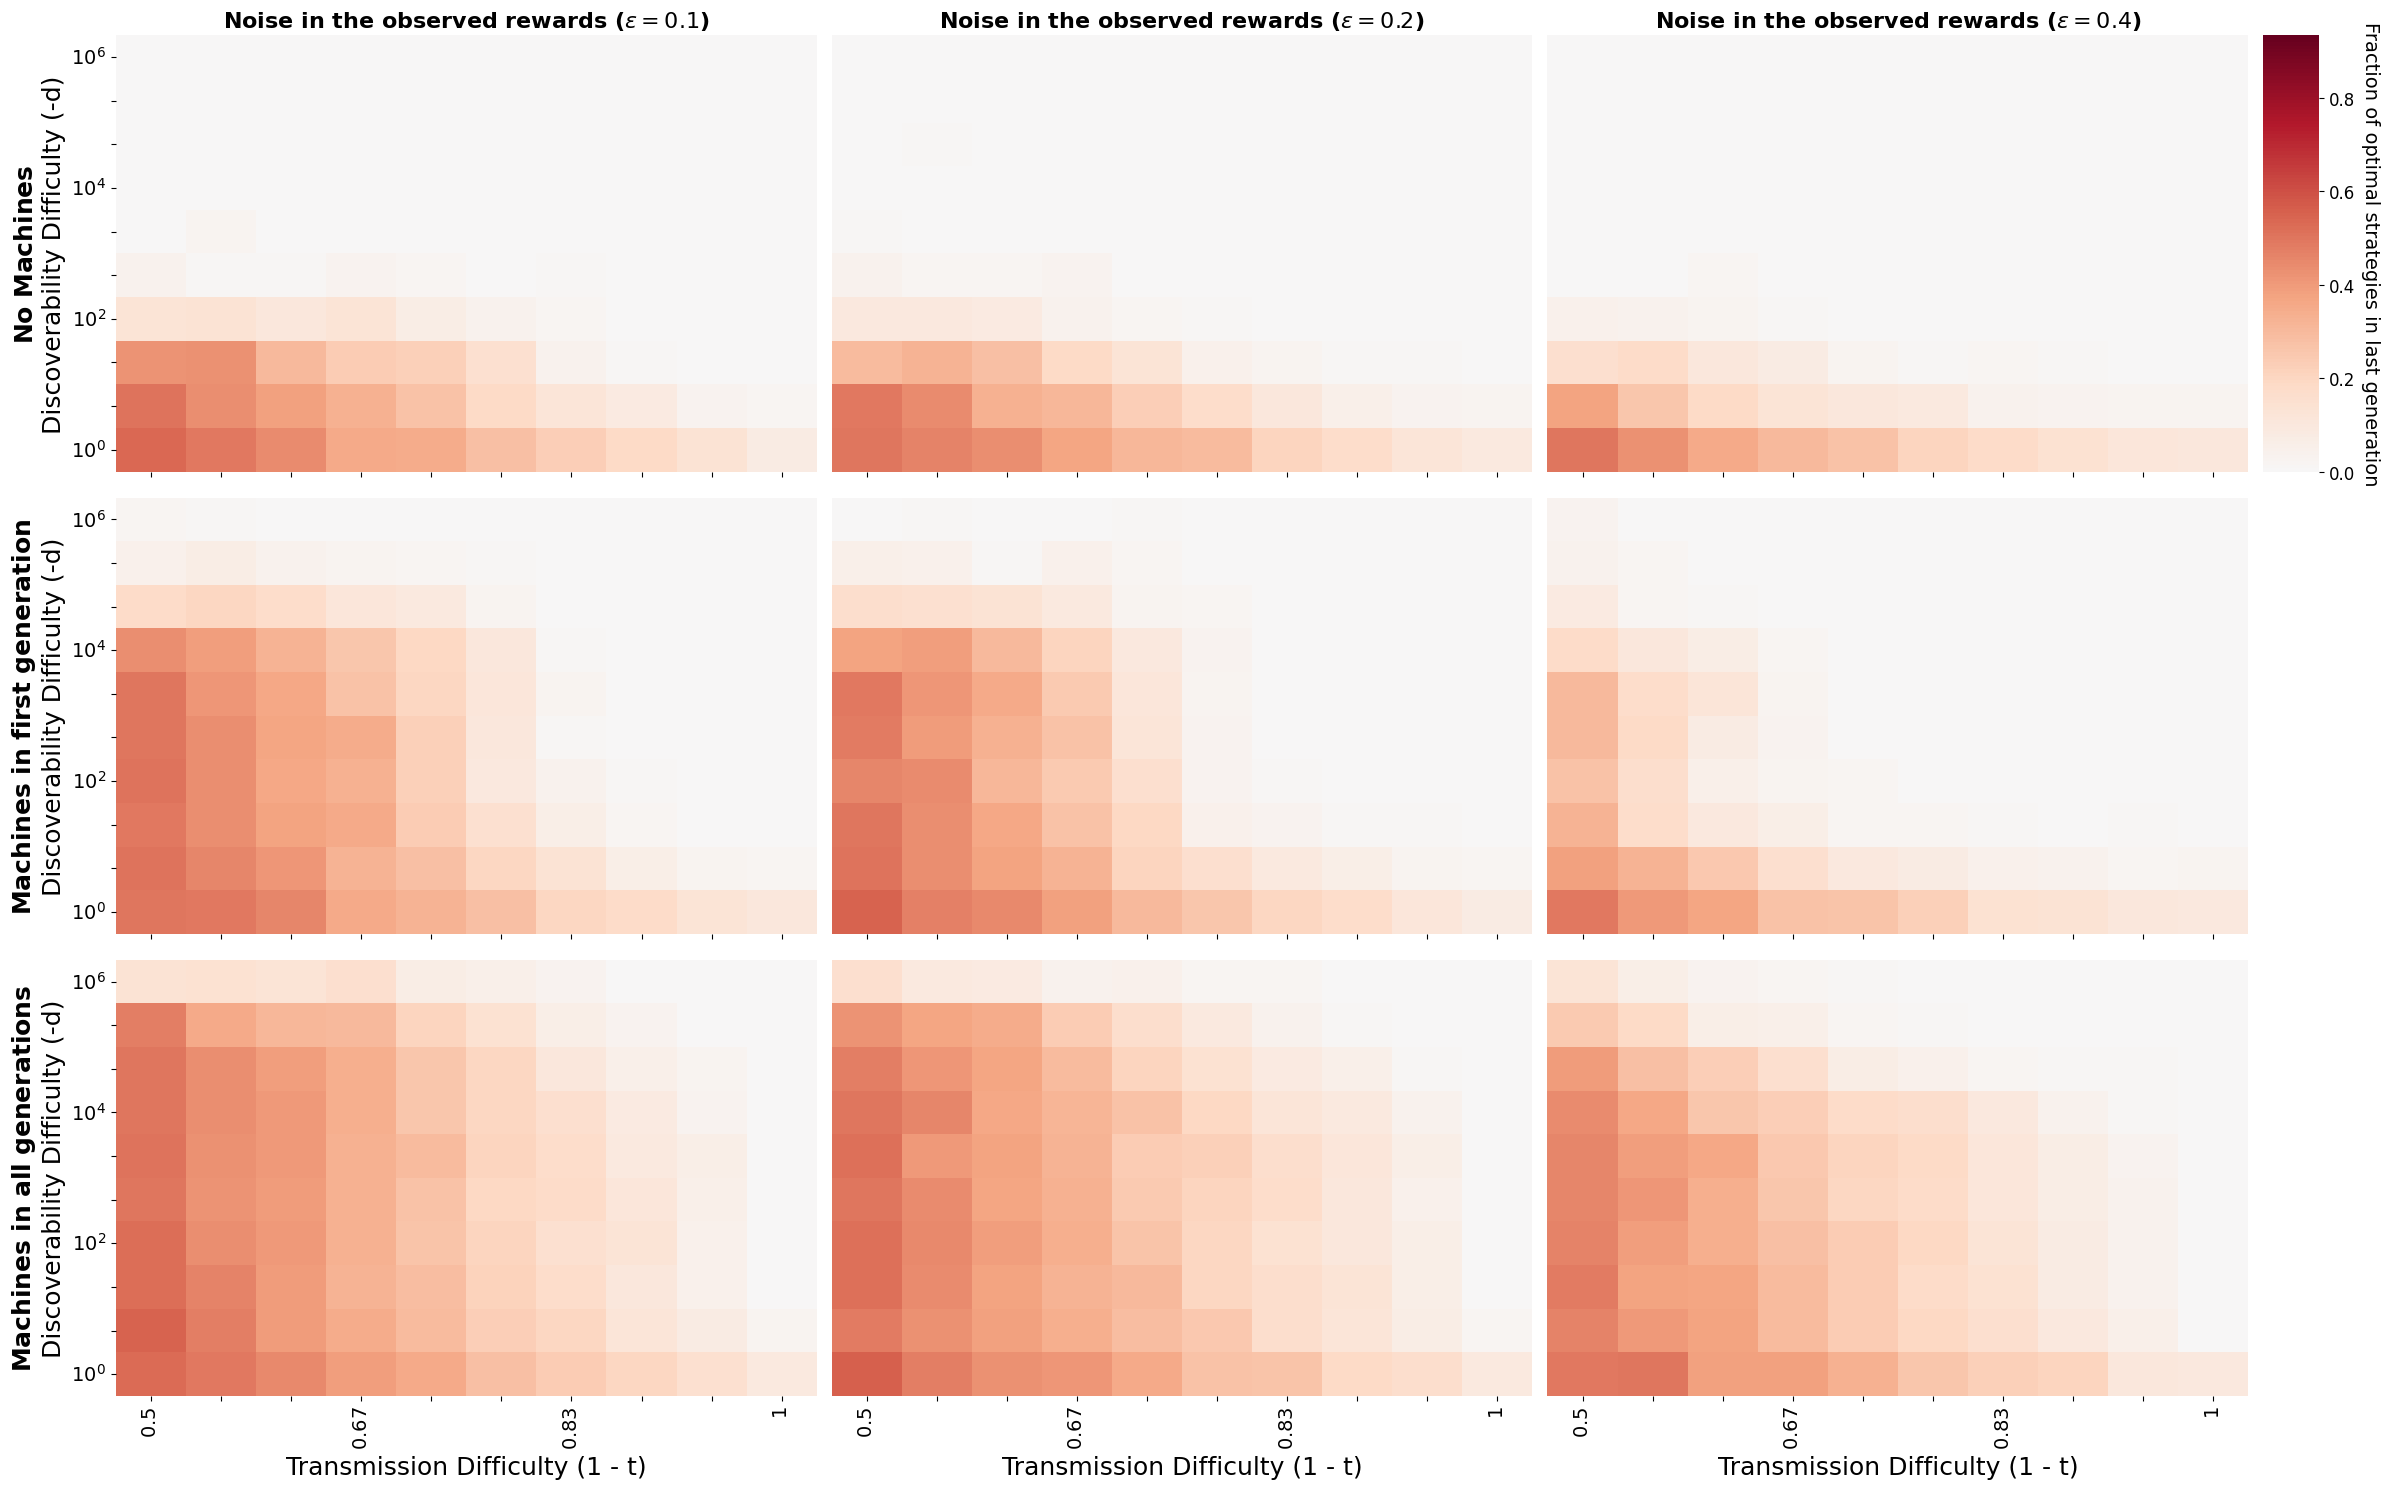

In [93]:
row_col = 'condition'
column_col = 'epsilon'
value_col = 'optimal'
x_col = 'discoverability difficulty'
y_col = 'learnability difficulty'


df = df_agg.reset_index()

# Get unique values for rows and columns
row_values = sorted(df[row_col].unique())
column_values = sorted(df[column_col].unique())

# Create a grid: rows = q_opt_machine, columns = K_machine
n_rows = len(row_values)
n_cols = len(column_values)

# Create figure with subplots (add one column for colorbar)
fig, axs = plt.subplots(n_rows, n_cols + 1, figsize=(6*(n_cols+1), 5*n_rows),
                        gridspec_kw={"width_ratios": [1]*n_cols + [0.08]})


def create_column_label(column_val):
    return rf"Noise in the observed rewards ($\epsilon = {column_val}$)"

condition_label_map = {
    'human': 'No Machines',
    'human-machine': 'Machines in first generation',
    'human-machine-all': 'Machines in all generations',
}


def create_row_label(row_val):
    row_label = condition_label_map.get(row_val, f"Condition: {row_val}")
    row_label = row_label.replace(" ", r"\ ")
    return rf"$\mathbf{{{row_label}}}$"

x_label = 'Transmission Difficulty (1 - t)'
y_label = 'Discoverability Difficulty (-d)'

main_label_font_size = 18
tick_label_font_size = 14
legend_font_size = 14
legend_tick_label_font_size = 12


# Find global min/max for consistent color scale
values = df[value_col].values
vmin = values.min()
vmax = values.max()

# Create heatmaps for each combination
for row_idx, row_val in enumerate(row_values):
    for col_idx, column_val in enumerate(column_values):
        # Filter data for this combination
        data_subset = df[
            (df[row_col] == row_val) & 
            (df[column_col] == column_val)
        ]
        
        # Create pivot table for heatmap
        heatmap_data = data_subset.pivot_table(
            index=x_col,
            columns=y_col,
            values=value_col
        )
        
        # Sort indices for proper display
        heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)
        heatmap_data = heatmap_data.sort_index(axis=1, ascending=False)
        
        ax = axs[row_idx, col_idx]
        
        # Create heatmap with data labels (like the earlier plot)
        hm = sns.heatmap(heatmap_data, ax=ax, cbar=False, cmap='RdBu_r', 
                        center=0, vmin=vmin, vmax=vmax,
                        xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index)
        
        # Invert x-axis
        ax.invert_xaxis()
        
        # Set labels
        if col_idx == 0:
            row_label = create_row_label(row_val)
            ax.set_ylabel(row_label + '\n' + y_label, fontsize=main_label_font_size)
            yvals = heatmap_data.index.values
            mask = np.isin(yvals, [0, 2, 4, 6])
            ax.set_yticklabels([rf"$10^{{{int(v)}}}$" if m else '' for v, m in zip(yvals, mask)], fontsize=tick_label_font_size)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        if row_idx == n_rows - 1:
            ax.set_xlabel(x_label, fontsize=main_label_font_size)
            xvals = heatmap_data.columns.values
            n_x = len(xvals)
            if n_x > 4:
                step = max(1, (n_x - 1) // 3)
                selected_indices = [0, step, 2*step, n_x-1]
            else:
                selected_indices = range(n_x)
            tick_labels = [rf"${xvals[i]:.2g}$" if i in selected_indices else '' for i in range(n_x)]
            ax.set_xticklabels(tick_labels, fontsize=tick_label_font_size)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        # Set title with column labels
        if row_idx == 0:
            col_label = create_column_label(column_val)
            ax.set_title(col_label, fontsize=16, fontweight='bold')

# Add colorbar in the rightmost column
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[0, n_cols])
cbar.outline.set_visible(False)
cbar.ax.set_ylabel('Fraction of optimal strategies in last generation', rotation=-90, va="bottom", fontsize=legend_font_size)
cbar.ax.tick_params(labelsize=legend_tick_label_font_size)
axs[0, n_cols].set_xticks([])

# Hide empty colorbar axes in other rows
for row_idx in range(1, n_rows):
    axs[row_idx, n_cols].set_visible(False)

plt.tight_layout()

plt.savefig('plots/reward_uncertainty.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('plots/reward_uncertainty.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
SKIP_SIMULATION = False


meta_conditions = [
    {
        'N_gen': 20,
        'N_mach': 5,
    },
    {
        'N_gen': 20,
        'N_mach': 1,
    },
    {
        'N_gen': 100,
        'N_mach': 5,
    },
    {
        'N_gen': 100,
        'N_mach': 1,
    },
]
df_res = []
if not SKIP_SIMULATION:
    for meta_condition in meta_conditions:
        N_gen = meta_condition['N_gen']
        N_mach = meta_condition['N_mach']

        G = 20
        K_demo = 1

        K_human = [10]
        K_machine = [10000]

        q_opt_human = [0.01]
        q_opt_machine = [0.5]

        n_teacher = [10] # Number of agents observed during social learning

        d_myopic = [0.5]  # Discoverability rate for myopic solutions
        d_optimal_log_ = np.linspace(0, -6, 10)

        lambda_ = np.linspace(0.0, 0.5, 10)  # Social learning rate
        conditions = ['human', 'human-machine', 'human-machine-all']
        tau =  [0.1]


        grid_d = {
            'N_gen': N_gen,
            'N_mach': N_mach,
            'condition': conditions,
            'd_myopic': d_myopic,
            'd_optimal_log': d_optimal_log_,
            'lambda': lambda_,
            'n_teacher': n_teacher,
            'replication': np.arange(R),
            'epsilon': [epsilon],
            'q_opt_human': q_opt_human,
            'K_human': K_human,
            'K_machine': K_machine,
            'q_opt_machine': q_opt_machine,
            'tau': tau,
        }

        d = grid_dict(grid_d)

        df = run_simulation(d, G, N_gen, N_mach, K_demo)
        gen_max = df.reset_index()['gen'].max()
        df = df[(df['gen'] == gen_max) & (df['is_machine'] == False)]
        df_agg = df.groupby(['rep','replication', 'K_machine', 'q_opt_machine', 'discoverability difficulty', 'learnability difficulty', 'condition', 'N_gen', 'N_mach']).agg(
            {
                'discovered': 'max',
                'optimal': 'mean',
                'myopic': 'mean',
                'rewards': 'mean',
            }
        ).sort_index()
        df_res.append(df_agg)
    df_agg = pd.concat(df_res)
    df_agg.to_parquet('../data/abm/robustness_results.parquet')
else:
    df_agg = pd.read_parquet('../data/abm/robustness_results.parquet')

0.0875
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
0.0175
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
0.0175
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
0.0035
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12


$\mathbf{20\ Agents\ per\ generation}$
$\mathbf{100\ Agents\ per\ generation}$


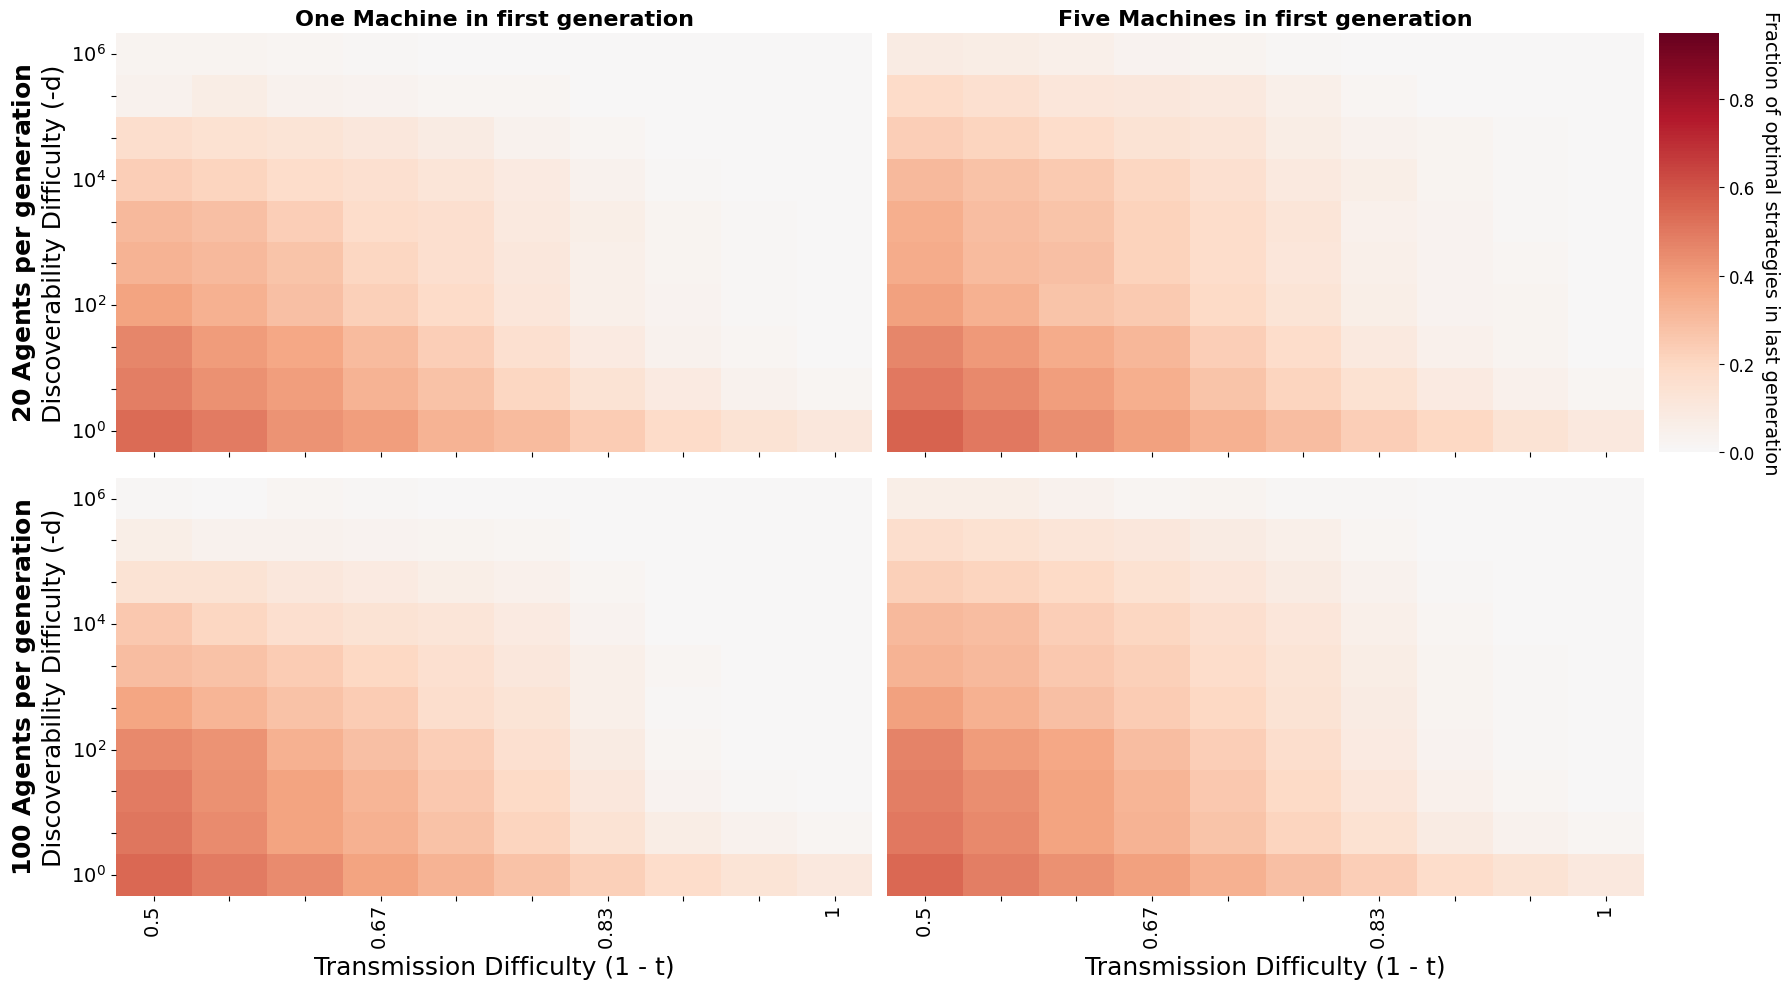

In [85]:
row_col = 'N_gen'
column_col = 'N_mach'
value_col = 'optimal'
x_col = 'discoverability difficulty'
y_col = 'learnability difficulty'


df = df_agg.reset_index()

# Get unique values for rows and columns
row_values = sorted(df[row_col].unique())
column_values = sorted(df[column_col].unique())

# Create a grid: rows = q_opt_machine, columns = K_machine
n_rows = len(row_values)
n_cols = len(column_values)

# Create figure with subplots (add one column for colorbar)
fig, axs = plt.subplots(n_rows, n_cols + 1, figsize=(6*(n_cols+1), 5*n_rows),
                        gridspec_kw={"width_ratios": [1]*n_cols + [0.08]})

label_map = {
    1: "One Machine in first generation",
    5: "Five Machines in first generation",
}

def create_column_label(column_val):
    return label_map.get(column_val, f"{column_val} Machines in first generation")


def create_row_label(row_val):
    row_label = f"{row_val} Agents per generation"
    row_label = row_label.replace(" ", r"\ ")
    return rf"$\mathbf{{{row_label}}}$"

x_label = 'Transmission Difficulty (1 - t)'
y_label = 'Discoverability Difficulty (-d)'

main_label_font_size = 18
tick_label_font_size = 14
legend_font_size = 14
legend_tick_label_font_size = 12


# Find global min/max for consistent color scale
values = df[value_col].values
vmin = values.min()
vmax = values.max()

# Create heatmaps for each combination
for row_idx, row_val in enumerate(row_values):
    for col_idx, column_val in enumerate(column_values):
        # Filter data for this combination
        data_subset = df[
            (df[row_col] == row_val) & 
            (df[column_col] == column_val)
        ]
        
        # Create pivot table for heatmap
        heatmap_data = data_subset.pivot_table(
            index=x_col,
            columns=y_col,
            values=value_col
        )
        
        # Sort indices for proper display
        heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)
        heatmap_data = heatmap_data.sort_index(axis=1, ascending=False)
        
        ax = axs[row_idx, col_idx]
        
        # Create heatmap with data labels (like the earlier plot)
        hm = sns.heatmap(heatmap_data, ax=ax, cbar=False, cmap='RdBu_r', 
                        center=0, vmin=vmin, vmax=vmax,
                        xticklabels=heatmap_data.columns, yticklabels=heatmap_data.index)
        
        # Invert x-axis
        ax.invert_xaxis()
        
        # Set labels
        if col_idx == 0:
            row_label = create_row_label(row_val)
            print(row_label)
            ax.set_ylabel(row_label + '\n' + y_label, fontsize=main_label_font_size)
            yvals = heatmap_data.index.values
            mask = np.isin(yvals, [0, 2, 4, 6])
            ax.set_yticklabels([rf"$10^{{{int(v)}}}$" if m else '' for v, m in zip(yvals, mask)], fontsize=tick_label_font_size)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        
        if row_idx == n_rows - 1:
            ax.set_xlabel(x_label, fontsize=main_label_font_size)
            xvals = heatmap_data.columns.values
            n_x = len(xvals)
            if n_x > 4:
                step = max(1, (n_x - 1) // 3)
                selected_indices = [0, step, 2*step, n_x-1]
            else:
                selected_indices = range(n_x)
            tick_labels = [rf"${xvals[i]:.2g}$" if i in selected_indices else '' for i in range(n_x)]
            ax.set_xticklabels(tick_labels, fontsize=tick_label_font_size)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        # Set title with column labels
        if row_idx == 0:
            col_label = create_column_label(column_val)
            ax.set_title(col_label, fontsize=16, fontweight='bold')

# Add colorbar in the rightmost column
cbar = hm.figure.colorbar(hm.collections[0], cax=axs[0, n_cols])
cbar.outline.set_visible(False)
cbar.ax.set_ylabel('Fraction of optimal strategies in last generation', rotation=-90, va="bottom", fontsize=legend_font_size)
cbar.ax.tick_params(labelsize=legend_tick_label_font_size)
axs[0, n_cols].set_xticks([])

# Hide empty colorbar axes in other rows
for row_idx in range(1, n_rows):
    axs[row_idx, n_cols].set_visible(False)

plt.tight_layout()

plt.savefig('plots/robustness.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('plots/robustness.pdf', bbox_inches='tight', pad_inches=0.1)